In [1]:
import redshift_connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv("simulated_curves.csv")
df = df[df.columns[1:]]

ret = df.pct_change()
ann_ret = ret.mean() * 8760
ann_vol = ret.std() * np.sqrt(8760)
sharpe = ann_ret / ann_vol

len(df.columns)

100

In [30]:
help(plt.subplot)

Help on function subplot in module matplotlib.pyplot:

subplot(*args, **kwargs)
    Add an Axes to the current figure or retrieve an existing Axes.
    
    This is a wrapper of `.Figure.add_subplot` which provides additional
    behavior when working with the implicit API (see the notes section).
    
    Call signatures::
    
       subplot(nrows, ncols, index, **kwargs)
       subplot(pos, **kwargs)
       subplot(**kwargs)
       subplot(ax)
    
    Parameters
    ----------
    *args : int, (int, int, *index*), or `.SubplotSpec`, default: (1, 1, 1)
        The position of the subplot described by one of
    
        - Three integers (*nrows*, *ncols*, *index*). The subplot will take the
          *index* position on a grid with *nrows* rows and *ncols* columns.
          *index* starts at 1 in the upper left corner and increases to the
          right. *index* can also be a two-tuple specifying the (*first*,
          *last*) indices (1-based, and including *last*) of the subplo

In [80]:
def fetch_OHLCV_df_from_redshift(asset_id_base, asset_id_quote, exchange_id):
    # Connect to Redshift cluster containing price data
    with redshift_connector.connect(
        host = 'project-poseidon.cpsnf8brapsd.us-west-2.redshift.amazonaws.com',
        database = 'token_price',
        user = 'administrator',
        password = 'Free2play2'
    ) as conn:
        with conn.cursor() as cursor:
            # Query to fetch OHLCV data for a token & exchange of interest
            title = asset_id_base + '-' + asset_id_quote
            query = """
            SELECT 
                time_period_end,
                price_open,
                price_high,
                price_low,
                price_close,
                volume_traded
            FROM token_price.coinapi.price_data_1h
            WHERE 
                asset_id_base = '{}' AND
                asset_id_quote = '{}' AND
                exchange_id = '{}'
            ORDER BY time_period_start ASC
            """.format(asset_id_base, asset_id_quote, 
                        exchange_id)

            # Execute query on Redshift and return result as a DataFrame
            cursor.execute(query)

            df = cursor.fetch_dataframe().rename({'time_period_end':'Date'}, axis = 1).set_index('Date').astype(float)
            return df

btc = fetch_OHLCV_df_from_redshift('BTC', 'USD', 'BITSTAMP')[['price_close']]
btc

,price_close
Date,
2011-09-13 14:00:00,6.00
2011-09-13 15:00:00,5.76
2011-09-13 16:00:00,5.65
2011-09-13 20:00:00,5.97
2011-09-14 08:00:00,5.62
...,...
2023-08-04 00:00:00,29176.00
2023-08-04 01:00:00,29213.00
2023-08-04 02:00:00,29180.00


In [110]:
bad_indices = (btc.index.to_series().diff() != pd.Timedelta(hours = 1))
len(bad_indices[bad_indices == True]) / len(btc)

0.01695484656651234

In [7]:
btc['ma_24'] = btc['price_close'].rolling(24).mean()
btc['ma_168'] = btc['price_close'].rolling(168).mean()
btc['ma_720'] = btc['price_close'].rolling(720).mean()

In [34]:
gt_ma_24 = btc[btc['price_close'] > btc['ma_24']]
gt_ma_168 = btc[btc['price_close'] > btc['ma_168']]
gt_ma_720 = btc[btc['price_close'] > btc['ma_720']]
gt_ma_all = btc[(btc['price_close'] > btc['ma_24']) & 
                (btc['price_close'] > btc['ma_168']) & 
                (btc['price_close'] > btc['ma_720'])]

<AxesSubplot:>

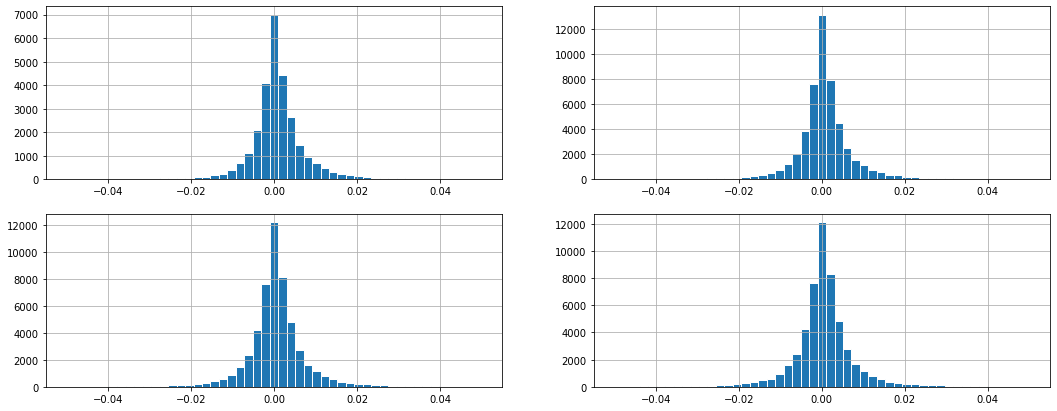

In [55]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 7))

gt_ma_all['price_close'].pct_change().hist(ec = 'w', bins = np.linspace(-0.05, 0.05, 50), ax = axs[0][0])

gt_ma_24['price_close'].pct_change().hist(ec = 'w', bins = np.linspace(-0.05, 0.05, 50), ax = axs[0][1])

gt_ma_168['price_close'].pct_change().hist(ec = 'w', bins = np.linspace(-0.05, 0.05, 50), ax = axs[1][0])

gt_ma_720['price_close'].pct_change().hist(ec = 'w', bins = np.linspace(-0.05, 0.05, 50), ax = axs[1][1])

In [62]:
# First 4 moments of each
mean_returns = gt_ma_all['price_close'].pct_change().mean()
var_returns = gt_ma_all['price_close'].pct_change().var()
skew_returns = gt_ma_all['price_close'].pct_change().skew()
kurt_returns = gt_ma_all['price_close'].pct_change().kurt()

print('mean: {}, var: {}, skew: {}, kurt: {}'.format(mean_returns, var_returns, skew_returns, kurt_returns))
print()

# First 4 moments of each
mean_returns = gt_ma_24['price_close'].pct_change().mean()
var_returns = gt_ma_24['price_close'].pct_change().var()
skew_returns = gt_ma_24['price_close'].pct_change().skew()
kurt_returns = gt_ma_24['price_close'].pct_change().kurt()

print('mean: {}, var: {}, skew: {}, kurt: {}'.format(mean_returns, var_returns, skew_returns, kurt_returns))
print()

# First 4 moments of each
mean_returns = gt_ma_168['price_close'].pct_change().mean()
var_returns = gt_ma_168['price_close'].pct_change().var()
skew_returns = gt_ma_168['price_close'].pct_change().skew()
kurt_returns = gt_ma_168['price_close'].pct_change().kurt()

print('mean: {}, var: {}, skew: {}, kurt: {}'.format(mean_returns, var_returns, skew_returns, kurt_returns))
print()

# First 4 moments of each
mean_returns = gt_ma_720['price_close'].pct_change().mean()
var_returns = gt_ma_720['price_close'].pct_change().var()
skew_returns = gt_ma_720['price_close'].pct_change().skew()
kurt_returns = gt_ma_720['price_close'].pct_change().kurt()

print('mean: {}, var: {}, skew: {}, kurt: {}'.format(mean_returns, var_returns, skew_returns, kurt_returns))
print()


mean: 0.00039919878316267135, var: 0.00016000104866443034, skew: -10.136323956243087, kurt: 458.2506070560912

mean: 0.0002808579465600534, var: 0.00026851500258923524, skew: 58.33970855493522, kurt: 9386.824782315092

mean: 0.00023893412243651449, var: 0.00012943606702635636, skew: -4.42334142894477, kurt: 273.22540374490404

mean: 0.00022525640505588308, var: 0.00012093737901863103, skew: -3.1621397762408536, kurt: 290.41727008572286

